In [2]:
import pandas as pd
from pathlib import Path
import tomllib

with open(Path.home() / '.cache' / 'finexp' / 'credentials.toml', 'rb') as f:
    cred = tomllib.load(f)

import fsspec

fs = fsspec.filesystem(
    'filecache',
    target_protocol='s3',
    target_options={
        'key': cred['key'],
        'secret': cred['secret'],
        'client_kwargs': {'endpoint_url': 'https://storage.yandexcloud.net'}
    },
    cache_storage=str(Path.home() / '.cache' / 'finexp'),
    check_files=True)

In [3]:
with fs.open('s3://snap-simfin/us-shareprices-daily.zip') as f:
    prices = pd.read_csv(f, compression='zip', sep=';')

prices['Date'] = pd.to_datetime(prices.Date)

sp500tr = pd.read_csv('sp500tr.csv', sep=';', header=None, names=['date', 'value'])
sp500tr['date'] = pd.to_datetime(sp500tr.date, dayfirst=True)
sp500tr = sp500tr.set_index('date').sort_index()
sp500tr['scaling'] = sp500tr.value.pct_change() + 1
sp500tr['scaling_c'] = sp500tr.scaling.cumprod()

prices['index_scaling_c'] = prices.Date.map(sp500tr.scaling_c)
prices = prices.set_index(['Ticker', 'Date']).sort_index()

prices['price_scaling'] = prices.groupby('Ticker').Close.pct_change() + 1
prices['div_scaling'] = (prices.Dividend / prices.Close).fillna(0) + 1
prices['scaling'] = prices.price_scaling * prices.div_scaling
prices['scaling_c'] = prices.groupby('Ticker').scaling.cumprod()

prices_c = prices.drop(prices[(prices.scaling > 100) | (prices.scaling < 0.01)].reset_index().Ticker.unique())
prices_c['scaling_c'] = prices_c.groupby('Ticker').scaling.cumprod()

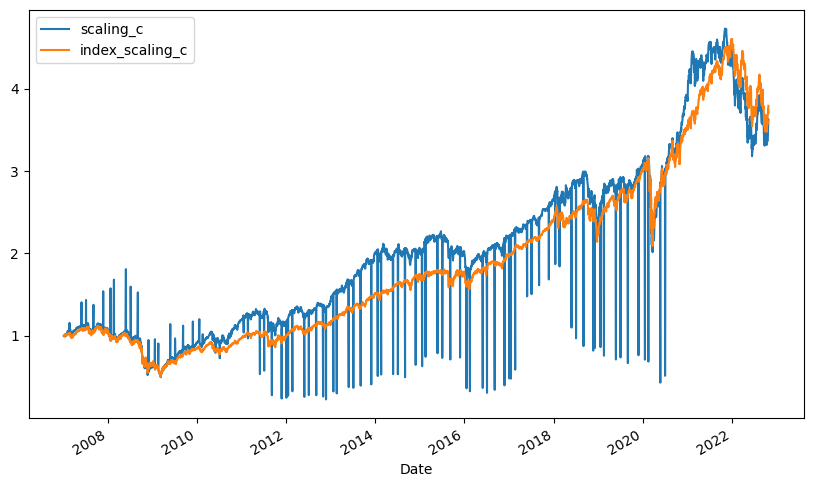

In [4]:
prices_c.groupby('Date').scaling_c.mean().plot(figsize=(10, 6), legend=True);
prices_c.groupby('Date').index_scaling_c.mean().plot(legend=True);

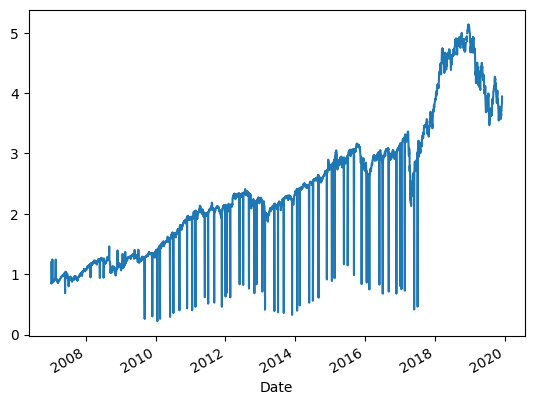

In [5]:
future = prices_c.groupby('Ticker').shift(-365*2)
future.groupby('Date').scaling_c.mean().plot();

In [6]:
prices_t = prices_c.join(future[['scaling_c', 'index_scaling_c']], how='inner', rsuffix='_future')
prices_t = prices_t.dropna(subset='scaling_c_future')
prices_t['scaling_cfr'] = (prices_t.scaling_c_future / prices_t.scaling_c) / (prices_t.index_scaling_c_future / prices_t.index_scaling_c)

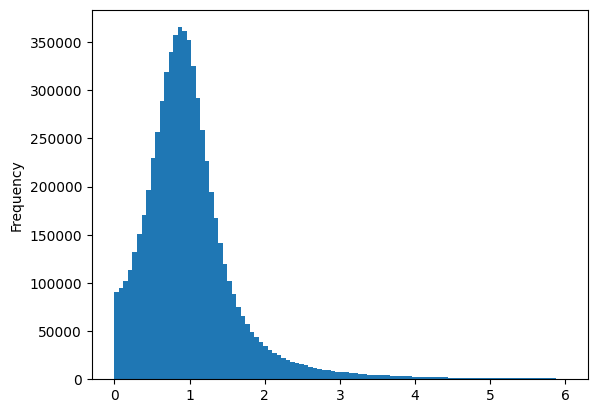

In [7]:
prices_t.scaling_cfr.plot.hist(range=[0, 6], bins=100);

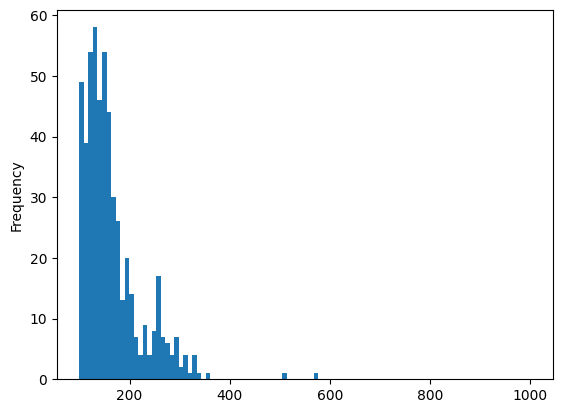

In [8]:
prices_t.scaling_cfr.plot.hist(range=[100, 1000], bins=100);

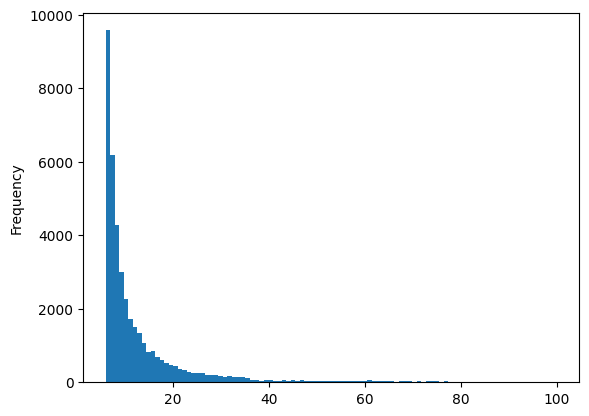

In [9]:
prices_t.scaling_cfr.plot.hist(range=[6, 100], bins=100);

In [10]:
prices_t['scaling_cfr_s'] = prices_t.scaling_cfr
prices_t.loc[prices_t.scaling_cfr_s < 1, 'scaling_cfr_s'] = -1/prices_t.scaling_cfr_s
prices_t.scaling_cfr_s = prices_t.scaling_cfr_s - prices_t.scaling_cfr_s.abs()/prices_t.scaling_cfr_s

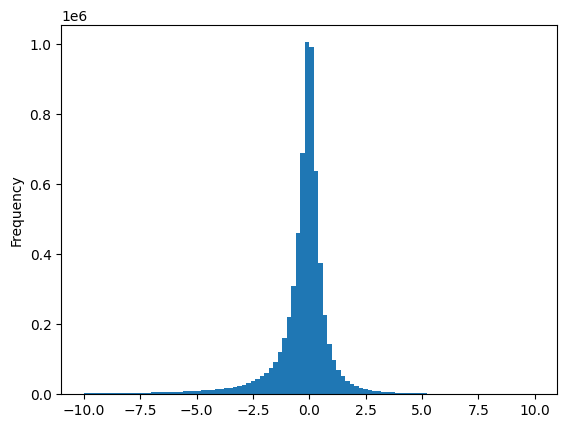

In [11]:
prices_t.scaling_cfr_s.plot.hist(range=[-10, 10], bins=100);

In [12]:
with fs.open('s3://snap-simfin/us-derived-shareprices-daily.zip') as f:
    dsp = pd.read_csv(f, compression='zip', sep=';')
    dsp['Date'] = pd.to_datetime(dsp.Date)
    dsp = dsp.set_index(['Ticker', 'Date'])

dsp = dsp.join(prices_t.scaling_cfr.dropna().to_frame(), how='inner')

dsp = dsp.drop(columns='SimFinId')

train = dsp.query("Date < '2019-01-01'")
test = dsp.query("Date >= '2019-01-01'")

In [13]:
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
now = datetime.now()

m = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent',
    objective='MAPE',
    max_depth=3,
    train_dir=f'train-{now.strftime("%Y-%m-%d-%H-%M-%S")}'
)

m.fit(train.drop(columns='scaling_cfr'), train.scaling_cfr)
m.score(test.drop(columns='scaling_cfr'), test.scaling_cfr)


-0.03516938375387468

In [14]:
pred = m.predict(test.drop(columns='scaling_cfr'))
test_p = test.copy()
test_p['pred'] = pred

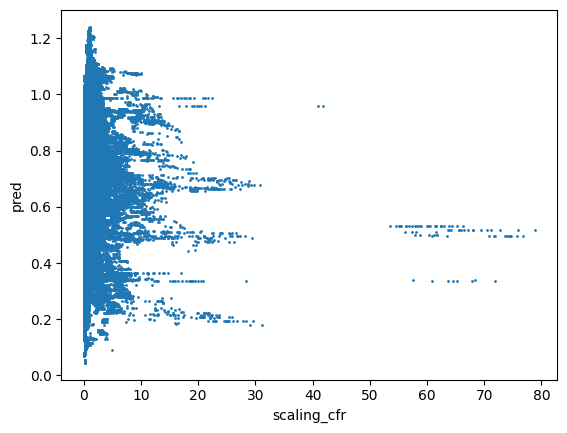

In [15]:
test_p.plot.scatter('scaling_cfr', 'pred', 1);

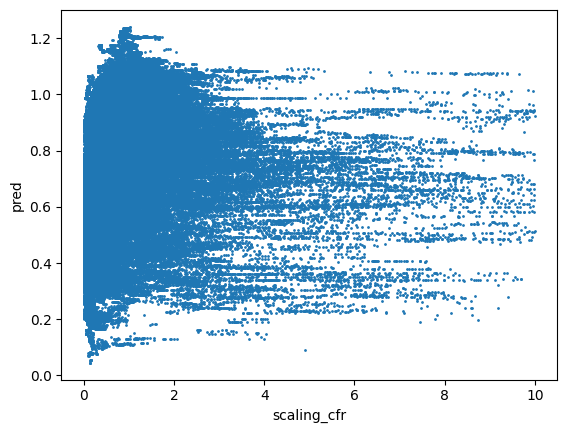

In [16]:
test_p[test_p.scaling_cfr < 10].plot.scatter('scaling_cfr', 'pred', 1);

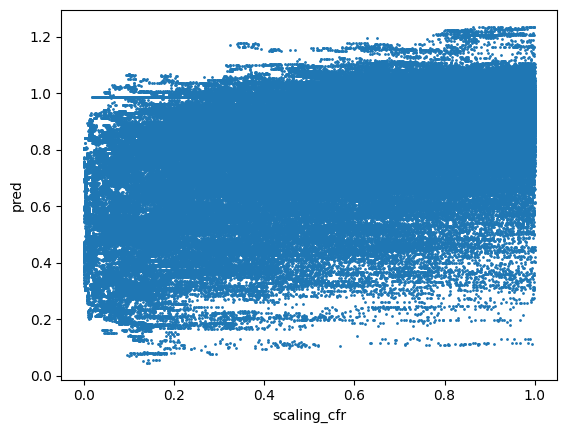

In [17]:
test_p[test_p.scaling_cfr < 1].plot.scatter('scaling_cfr', 'pred', 1);

In [18]:
m.score(test[test.scaling_cfr < 1].drop(columns='scaling_cfr'), test[test.scaling_cfr < 1].scaling_cfr)

-0.5529788417627206

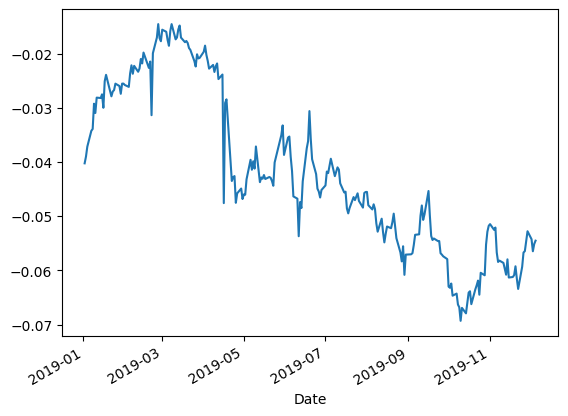

In [19]:
from sklearn.metrics import r2_score

def r_squared(x):
    return r2_score(x['scaling_cfr'], x['pred'])

test_p.groupby('Date').apply(r_squared).plot();

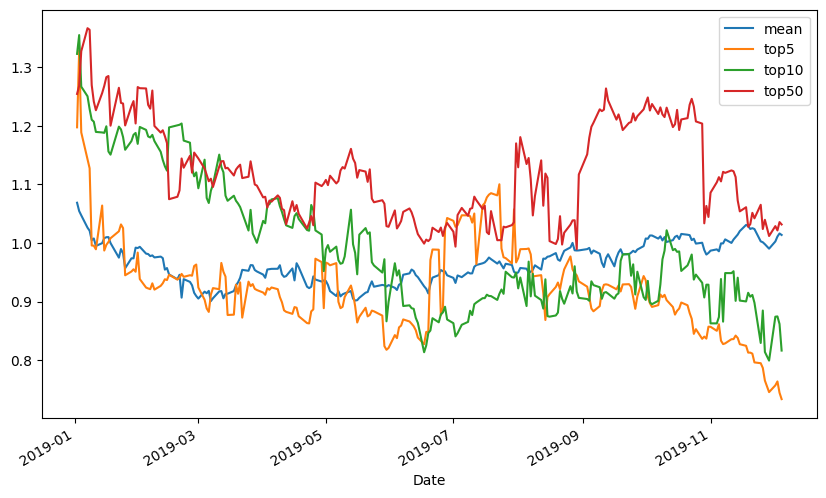

In [20]:
test_p.scaling_cfr.groupby('Date').mean().rename('mean').plot(figsize=(10, 6), legend=True)
top5 = test_p.sort_values('pred', ascending=False).groupby('Date').head(5).scaling_cfr.groupby('Date').mean().rename('top5')
top5.plot(legend=True)
top10 = test_p.sort_values('pred', ascending=False).groupby('Date').head(10).scaling_cfr.groupby('Date').mean().rename('top10')
top10.plot(legend=True)
top50 = test_p.sort_values('pred', ascending=False).groupby('Date').head(50).scaling_cfr.groupby('Date').mean().rename('top50')
top50.plot(legend=True);

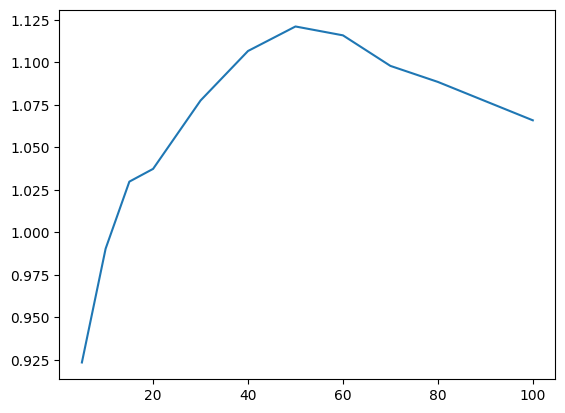

In [21]:
pd.Series({
    i: test_p.sort_values('pred', ascending=False).groupby('Date').head(i).scaling_cfr.mean()
    for i in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100]
}).plot();

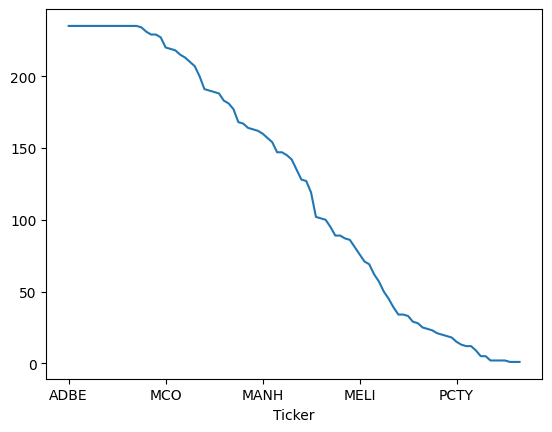

In [22]:
cnt = test_p.sort_values('pred', ascending=False).groupby('Date').head(50).groupby('Ticker').scaling_cfr.count().sort_values(ascending=False)
cnt.plot();

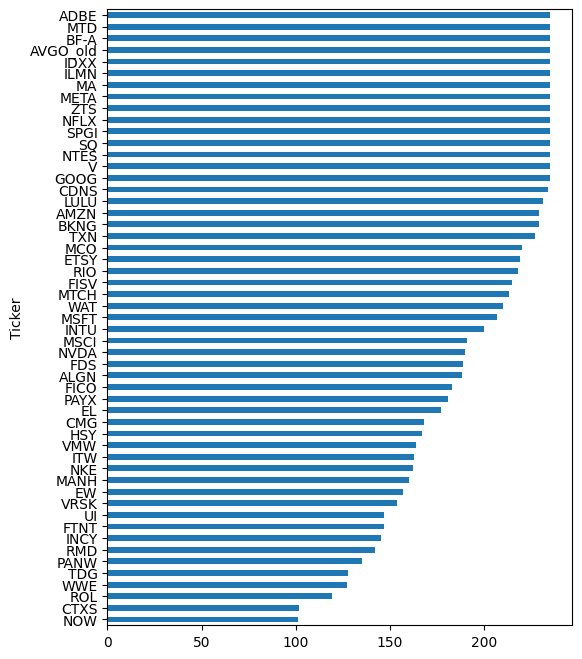

In [23]:
cnt[cnt > 100].sort_values().plot.barh(figsize=(6,8));

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


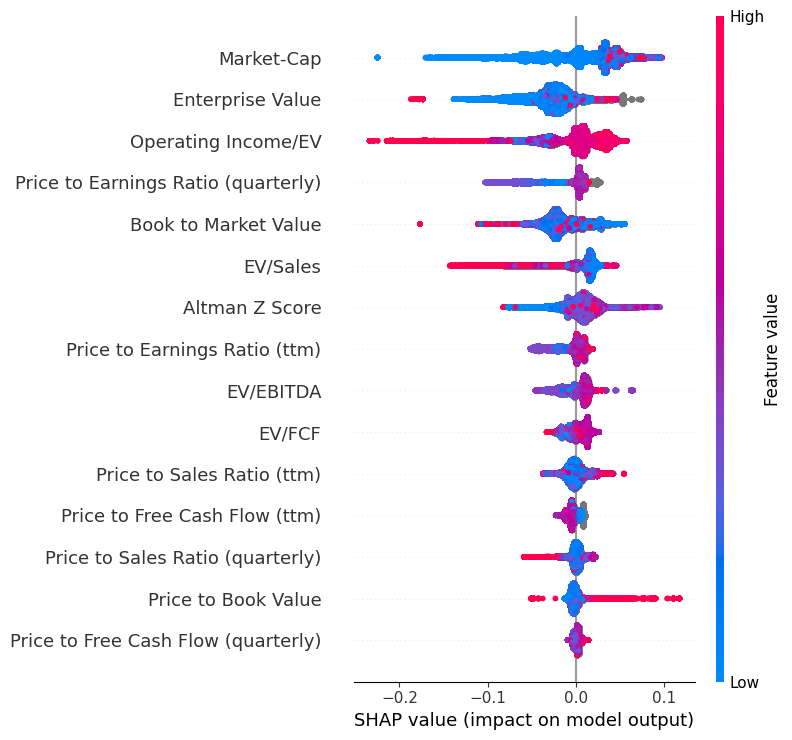

In [25]:
import shap

from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(test.drop(columns='scaling_cfr'))
shap.summary_plot(shap_values, test.drop(columns='scaling_cfr'))